In [1]:
import os

import sys
os.chdir("/Users/zyxu/Documents/py/kris")
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import func.prepro as pp
import gc
from tqdm import tqdm

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from func.prepro import SingleCellDataset, SingleCellDataset_test

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))

In [2]:
DATA_DIR = "open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

inputs

In [25]:
import func.prepro as pp
train_multi_inputs = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, 0, 2500)

In [ ]:
train_multi_inputs = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, 2500, 5000)

In [34]:
sys.getsizeof(train_multi_inputs["matrix"])/1024/1024/1024

0.9866618663072586

In [35]:
train_multi_inputs['matrix'].shape

(105942, 2500)

In [36]:
colmean_input = train_multi_inputs['matrix'].mean(axis = 0)

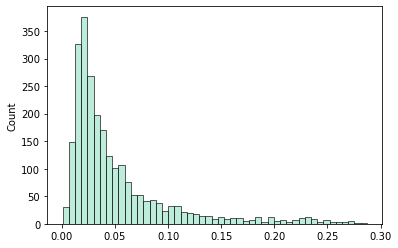

In [37]:
sns.histplot(data=colmean_input)

In [38]:
colmean_input.min()

0.0006293034

### targets

read targets

In [3]:
train_multi_targets = pp.readH5pyFile(FP_MULTIOME_TRAIN_TARGETS)

In [4]:
colmean_target = train_multi_targets["block0_values"].mean(axis = 0)

In [31]:
train_multi_targets["block0_values"].shape

(105942, 23418)

In [32]:
colmean_target[:10]

array([0.49906692, 0.32367814, 0.33146796, 0.08396932, 0.03434844,
       0.25019547, 0.00465303, 0.10219903, 0.7860585 , 1.302035  ],
      dtype=float32)

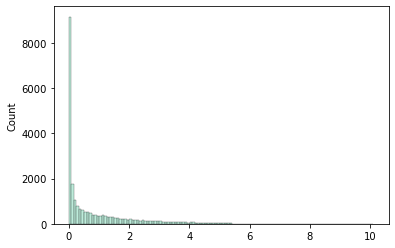

In [17]:
sns.histplot(data=colmean_target)

In [6]:
(colmean_target <= 0.25).sum()/colmean_target.shape[0]

0.5109317618925613

In [7]:
idx_zero =  np.where(colmean_target <= 0.25)[0]

In [8]:
idx_non_zero = np.where(colmean_target > 0.25)[0]

In [35]:
# train_multi_targets["axis0"][colmean_target <= 0.25]
train_multi_targets["axis0"][idx_non_zero]

array([b'ENSG00000245105', b'ENSG00000166535', b'ENSG00000184389', ...,
       b'ENSG00000198205', b'ENSG00000198455', b'ENSG00000203995'],
      dtype='|S15')

In [9]:
targets_non_zero = train_multi_targets['block0_values'][:,idx_non_zero]
targets_non_zero

array([[0.      , 0.      , 0.      , ..., 5.583255, 0.      , 4.893861],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 5.107832],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 4.871117, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 5.659341, 0.      , 0.      ]],
      dtype=float32)

In [18]:
targets_non_zero.shape

(105942, 11453)

kmeans

In [21]:
targets_non_zero.T.shape

(11453, 105942)

In [19]:
from sklearn.cluster import KMeans
km = KMeans(
    init="random",
    n_clusters= 100,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [ ]:
km.fit(targets_non_zero.T)

partial PCA

In [6]:
# test_multi = SingleCellDataset_test(FP_MULTIOME_TEST_INPUTS,testresponse =20)
test_multi = SingleCellDataset(FP_MULTIOME_TRAIN_INPUTS)
testloader_multi = DataLoader(test_multi, batch_size=1024)
# train_multi = SingleCellDataset_test(FP_MULTIOME_TRAIN_INPUTS,FP_MULTIOME_TRAIN_TARGETS,testresponse =20)
train_multi = SingleCellDataset(FP_MULTIOME_TRAIN_INPUTS,FP_MULTIOME_TRAIN_TARGETS)
trainloader_multi = DataLoader(train_multi, batch_size=1024)

In [8]:
# from sklearn.cluster import MiniBatchKMeans
# km = MiniBatchKMeans(n_clusters=100,
#                     random_state=0,
#                     batch_size=256)
    
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=1000, 
                    batch_size=1024)

In [9]:
for cell_ids, inputs, targets in tqdm(trainloader_multi):
    i = 0
    ## first filter the cells to be estimated
    ipca.fit(inputs)
    i += 1
    if i>=3:
        break

  0%|          | 0/104 [00:00<?, ?it/s]

In [25]:
km.labels_.shape

(256,)

In [9]:
cell_ids, inputs, targets = next(iter(trainloader_multi))

In [10]:
inputs.shape

torch.Size([64, 228942])

In [26]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 0], [4, 4],
              [4, 5], [0, 1], [2, 2],
              [3, 2], [5, 5], [1, -1]])
kmeans = MiniBatchKMeans(n_clusters=2,
                          random_state=0,
                          batch_size=6)
kmeans = kmeans.partial_fit(X[0:6,:])
kmeans = kmeans.partial_fit(X[6:12,:])
kmeans.cluster_centers_

array([[2. , 1. ],
       [3.5, 4.5]])

In [27]:
kmeans.labels_

array([1, 0, 0, 0, 1, 0], dtype=int32)